# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
df.shape

(68817, 86)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     688

In [7]:
pd.set_option('display.max_rows', None)  # or 1000
df.nunique(axis=0)

loan_amnt                      1398
int_rate                         52
installment                    8810
home_ownership                    4
annual_inc                     6090
verification_status               3
issue_d                           3
loan_status                       2
pymnt_plan                        1
dti                            5696
delinq_2yrs                      18
inq_last_6mths                    6
open_acc                         63
pub_rec                           5
revol_bal                     32706
total_acc                       107
initial_list_status               2
out_prncp                     19682
out_prncp_inv                 20910
total_pymnt                   28050
total_pymnt_inv               29072
total_rec_prncp               18245
total_rec_int                 24543
total_rec_late_fee               58
recoveries                        1
collection_recovery_fee           1
last_pymnt_amnt               12709
next_pymnt_d                

In [8]:
df['recoveries'].value_counts()

0.0    68817
Name: recoveries, dtype: int64

In [9]:
df['pymnt_plan'].value_counts()

n    68817
Name: pymnt_plan, dtype: int64

In [10]:
# Drop all unnecessary columns with only a single value.
pd.set_option('display.max_columns', None)  # or 1000
df.drop(columns=['pymnt_plan','recoveries','collection_recovery_fee','policy_code','acc_now_delinq','num_tl_120dpd_2m','num_tl_30dpd','tax_liens','hardship_flag','debt_settlement_flag'], inplace=True)
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,next_pymnt_d,collections_12_mths_ex_med,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,w,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,375.35,May-2019,0.0,Individual,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,3.0,85.7,100.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,w,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,929.09,May-2019,0.0,Individual,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,6.0,91.2,50.0,1.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,w,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,529.88,May-2019,0.0,Individual,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,4.0,66.7,50.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,w,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,353.55,May-2019,0.0,Individual,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,1.0,100.0,50.0,1.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,w,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,520.39,May-2019,0.0,Individual,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,1.0,100.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [11]:
# Update the DataFrame to numerical values:
df_encoded = pd.get_dummies(df, columns=['home_ownership','verification_status','issue_d','initial_list_status','next_pymnt_d','application_type',], drop_first=True)
df_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_w,next_pymnt_d_May-2019,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,375.35,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,3.0,85.7,100.0,0.0,65687.0,38199.0,2000.0,61987.0,0,0,1,1,0,0,1,1,1,0
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,929.09,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,6.0,91.2,50.0,1.0,271427.0,60641.0,41200.0,49197.0,1,0,0,0,1,0,1,1,1,0
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,529.88,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,4.0,66.7,50.0,0.0,60644.0,45684.0,7500.0,43144.0,1,0,0,0,1,0,1,1,1,0
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,353.55,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,1.0,100.0,50.0,1.0,99506.0,68784.0,19700.0,76506.0,0,0,1,0,1,0,1,1,1,0
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,520.39,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,1.0,100.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,1,0,0,0,0,0,1,1,1,0


## Split the Data into Training and Testing

In [12]:
# Create our features
X = df_encoded.drop(columns=['loan_status'])

In [13]:
# Create our target
y = df_encoded['loan_status'].to_frame('loan_status')
y.head()

,loan_status
0,low_risk
1,low_risk
2,low_risk
3,low_risk
4,low_risk


In [14]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_w,next_pymnt_d_May-2019,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.00000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,24.666347,16018.845833,16015.919519,970.639473,970.431151,658.748750,311.855687,0.035072,517.202218,0.016188,188.664298,1.634976e+05,1.023047,3.290481,0.843730,1.909644,14.303152,4.324044e+04,69.21191,1.240042,2.622245,6297.491710,55.702472,42431.895360,1.382071,1.687795,2.189023,4.827572,14142.936193,16991.852667,48.330667,0.006830,2.347065,125.468605,175.136841,14.294215,7.179781,1.441882,24.714954,7.688028,0.472485,3.806123,5.648038,5.135156,7.414403,9.500153,8.630818,13.517663,5.653036,12.571995,0.052138,2.219423,95.057627,30.626217,0.125972,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,0.526309,0.106747,0.357659,0.373992,0.148001,0.451066,0.177238,0.876121,0.616839,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,12.318917,10002.695495,10004.985940,1229.563301,1229.569864,1126.237377,279.786954,1.086720,816.021053,0.134774,1808.457195,1.723699e+05,1.176782,2.965579,0.970543,1.544994,13.972619,4.956130e+04,22.33711,1.471745,2.502608,5702.281757,18.495480,37166.229316,1.543220,2.852664,2.396186,3.145377,15863.878993,20447.276820,28.106287,0.087327,301.312407,56.968853,99.149467,17.417118,6.303066,1.747777,32.130889,6.034861,1.410819,2.464504,3.470941,3.230651,4.581371,7.573846,5.056994,8.026158,3.472679,6.021318,0.390633,1.897432,8.326426,33.631463,0.336732,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.499311,0.308793,0.479314,0.483865,0.355104,0.497603,0.381873,0.329446,0.486161,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000

In [15]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [16]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [17]:
X_train.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       '

In [18]:
X_train.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_w,next_pymnt_d_May-2019,application_type_Joint App
45047,10000.0,0.0819,314.25,106000.0,10.51,0.0,0.0,9.0,0.0,8248.0,13.0,9506.32,9506.32,621.68,621.68,493.68,128.00,0.0,314.25,0.0,0.0,22980.0,2.0,3.0,1.0,2.0,8.0,14732.0,47.0,2.0,3.0,4232.0,35.0,34800.0,0.0,0.0,0.0,5.0,2553.0,26552.0,23.7,0.0,0.0,179.0,156.0,6.0,6.0,0.0,6.0,17.0,0.0,6.0,6.0,6.0,6.0,7.0,6.0,6.0,6.0,9.0,0.0,3.0,100.0,0.0,0.0,66134.0,22980.0,34800.0,31334.0,0,0,1,0,0,1,0,1,0,0
3221,35000.0,0.1240,785.65,115000.0,25.30,0.0,0.0,13.0,0.0,4.0,36.0,34576.02,34551.32,761.54,761.00,423.98,337.56,0.0,785.65,0.0,0.0,613120.0,1.0,6.0,1.0,3.0,7.0,192813.0,102.0,1.0,2.0,4.0,69.0,26800.0,2.0,1.0,2.0,5.0,47163.0,23096.0,0.0,0.0,0.0,163.0,218.0,6.0,6.0,6.0,6.0,1.0,0.0,1.0,1.0,4.0,9.0,15.0,5.0,14.0,1.0,13.0,0.0,2.0,91.2,0.0,0.0,663904.0,196623.0,23100.0,182617.0,1,0,0,0,1,0,1,0,1,1
63821,18000.0,0.1797,456.79,58000.0,23.53,0.0,0.0,19.0,0.0,22370.0,25.0,17429.83,17405.62,1352.40,1350.52,570.17,782.23,0.0,456.79,0.0,0.0,315146.0,0.0,0.0,0.0,0.0,32.0,1485.0,25.0,1.0,10.0,4873.0,63.0,32000.0,1.0,0.0,0.0,10.0,16587.0,3408.0,83.5,0.0,0.0,208.0,130.0,7.0,7.0,2.0,7.0,13.0,0.0,12.0,17.0,12.0,12.0,5.0,17.0,18.0,17.0,19.0,0.0,1.0,100.0,66.7,0.0,341403.0,23855.0,20600.0,6000.0,1,0,0,1,0,1,0,0,1,0
60268,40000.0,0.1614,975.71,48000.0,30.85,1.0,0.0,9.0,0.0,6306.0,23.0,38670.32,38670.32,3016.80,3016.80,1329.68,1687.12,0.0,975.71,0.0,0.0,133563.0,1.0,2.0,0.0,1.0,15.0,46023.0,77.0,1.0,3.0,5961.0,59.0,29000.0,0.0,1.0,0.0,4.0,14840.0,12894.0,32.8,0.0,0.0,195.0,92.0,4.0,4.0,3.0,4.0,15.0,1.0,2.0,2.0,3.0,9.0,7.0,6.0,13.0,2.0,9.0,0.0,1.0,87.0,0.0,0.0,188591.0,52329.0,19200.0,60131.0,1,0,0,0,1,1,0,1,1,1
26061,3150.0,0.1131,103.60,84000.0,13.23,0.0,1.0,14.0,1.0,6240.0,21.0,3001.48,2739.45,205.22,187.30,148.52,56.70,0.0,103.60,0.0,0.0,19659.0,3.0,3.0,0.0,2.0,13.0,13419.0,40.0,4.0,4.0,1420.0,29.0,34200.0,3.0,0.0,1.0,6.0,1404.0,20879.0,17.8,0.0,0.0,120.0,258.0,3.0,3.0,0.0,3.0,4.0,0.0,7.0,10.0,7.0,11.0,4.0,11.0,17.0,10.0,14.0,0.0,4.0,82.4,0.0,1.0,68143.0,19659.0,25400.0,33943.0,0,0,1,1,0,0,0,0,1,0


In [19]:
X_train.shape

(51612, 79)

X_train_binary = X_train[['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'issue_d_Jan-2019', 'issue_d_Mar-2019', 'initial_list_status_w',
       'next_pymnt_d_May-2019', 'application_type_Joint App']]
X_train_binary.head()

X_train_subset = X_train.drop(columns=(['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'issue_d_Jan-2019', 'issue_d_Mar-2019', 'initial_list_status_w',
       'next_pymnt_d_May-2019', 'application_type_Joint App']))
X_train_subset.head()

X_test_binary = X_test[['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'issue_d_Jan-2019', 'issue_d_Mar-2019', 'initial_list_status_w',
       'next_pymnt_d_May-2019', 'application_type_Joint App']]
X_test_binary.head()

X_test_subset = X_test.drop(columns=(['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'issue_d_Jan-2019', 'issue_d_Mar-2019', 'initial_list_status_w',
       'next_pymnt_d_May-2019', 'application_type_Joint App']))
X_test_subset.head()

# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
# NOTE:  I left out the binary columns.
X_scaler = scaler.fit(X_train_subset)

### Using StandardScaler on Linear X_train Data & concatenating it to the binary data (from the get dummies classification data) that wasn't scaled with the scaled data.

# Scale the training and testing data
# X_train_scaled = np.concatenate(X_scaler.transform(X_train_subset), X_test_binary,  axis=1)
X_train_scaled = X_scaler.transform(X_train_subset)

X_train_scaled_DF = pd.DataFrame(X_train_scaled)
X_train_scaled_DF.head()

# NOTE:  This creates NaN values for all of the binary data.  Also, the Standardized data has been reindexed.
X_train_finalDF = pd.concat([X_train_scaled_DF,X_train_binary])
X_train_finalDF.head()

### Try Concatenating with Numpy before converting to DataFrame to see if it preserves the order(index) of both the datasets together.

# numpy.concatenate((a1, a2, ...), axis=0, out=None, dtype=None, casting="same_kind")
X_train_finalDF = np.concatenate((X_train_scaled,X_train_binary))
# X_train_finalDF = pd.concat([X_train_scaled_DF,X_train_binary])

## NEW SOLUTION: USE SCIKIT-LEARN'S ColumnTransformer():
OneHotEncoder versus GetDummies:
https://www.quora.com/When-would-you-choose-to-use-pandas-get_dummies-vs-sklearn-OneHotEncoder
Both options are equally handy but the major difference is that OneHotEncoder is a transformer class, so it can be fitted to data. Once fitted, it is able to transform validation data based on the categories it learned. That is, if previously unseed data contains new categories and is being transformed, the encoder will ignore them or raise an error (depending on handle_unknown parameter). Also, OneHotEncoder matches scikit-learn’s transformer API so that one can use it in pipelines for convenience.

Basically, get_dummies is used in exploratory analysis, whereas OneHotEncoder in computation and estimation. See documentations for more details.

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [22]:
ohe = OneHotEncoder()
sc = StandardScaler()

In [23]:
ct = make_column_transformer(
    (sc, ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
          'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
          'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
          'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
          'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
          'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
          'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
          'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
          'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
          'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
          'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
          'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
          'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
          'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
          'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
          'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
          'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']),
    (ohe, ['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'issue_d_Jan-2019', 'issue_d_Mar-2019', 'initial_list_status_w',
       'next_pymnt_d_May-2019', 'application_type_Joint App'])
)

In [25]:
X_train_scaled = ct.fit_transform(X_train)
print(type(X_train_scaled))

<class 'numpy.ndarray'>


In [27]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88
0,-0.652449,-0.950110,-0.579678,0.153455,-0.551568,-0.302014,-0.653219,-0.596929,-0.372544,-0.430243,-0.949865,-0.654229,-0.653798,-0.293073,-0.292897,-0.150761,-0.655820,-0.032038,-0.261750,-0.119313,-0.100762,-0.815557,0.834655,-0.100033,0.160197,0.054526,-0.446401,-0.575130,-0.998298,0.524642,0.155756,-0.364775,-1.122761,-0.206574,-0.897591,-0.593871,-0.910254,0.056633,-0.727334,0.466179,-0.876495,-0.080035,-0.00808,0.933728,-0.195306,-0.476594,-0.190684,-0.828815,-0.583644,1.530588,-0.333658,0.892584,0.103024,0.268642,-0.309037,-0.332881,-0.519942,-0.937155,0.101489,-0.594533,-0.134243,0.416288,0.592586,-0.911469,-0.372409,-0.747024,-0.669462,0.186296,-0.480672,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.777157,-0.073181,1.053170,0.231057,0.168424,-0.302014,-0.653219,0.066848,-0.372544,-0.808002,0.916582,1.848992,1.846396,-0.174413,-0.174695,-0.215850,0.091280,-0.032038,0.349452,-0.119313,-0.100762,2.593570,-0.016458,0.903710,0.160197,0.700281,-0.517252,2.994608,1.469347,-0.157900,-0.245627,-1.101023,0.716305,-0.421694,0.402327,-0.243058,-0.076092,0.056633,2.056325,0.297349,-1.719761,-0.080035,-0.00808,0.653262,0.430394,-0.476594,-0.190684,2.609511,-0.583644,-1.110769,-0.333658,-1.137578,-1.336095,-0.350974,0.344876,0.722781,-0.717772,0.058857,-1.336904,0.069451,-0.134243,-0.111001,-0.463798,-0.911469,-0.372409,2.339870,2.343668,-0.248746,2.481817,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.125024,1.087031,-0.085944,-0.260423,0.082259,-0.302014,-0.653219,1.062513,-0.372544,0.216861,0.023934,0.136937,0.134774,0.326886,0.325466,-0.079331,1.676570,-0.032038,-0.076937,-0.119313,-0.100762,0.872230,-0.867570,-1.103777,-0.868554,-1.236983,1.254011,-0.840674,-1.985355,-0.157900,2.965436,-0.253154,0.391764,-0.281866,-0.247632,-0.593871,-0.910254,1.648128,0.148386,-0.664435,1.251241,-0.080035,-0.00808,1.442072,-0.457697,-0.419780,-0.032449,0.317294,-0.552613,0.870249,-0.333658,3.328778,3.269085,2.127491,0.998788,-0.596796,1.656189,0.556863,3.265953,1.065428,-0.134243,-0.638291,0.592586,1.073342,-0.372409,0.674469,-0.654278,-0.341703,-0.976773,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,2.263078,0.705848,1.711505,-0.346648,0.438604,1.101889,-0.653219,-0.596929,-0.372544,-0.519230,-0.138366,2.257810,2.257588,1.739001,1.739171,0.629936,4.902586,-0.032038,0.595877,-0.119313,-0.100762,-0.176740,-0.016458,-0.434615,-0.868554,-0.591229,0.049552,0.052117,0.347690,-0.157900,0.155756,-0.063693,0.175403,-0.362536,-0.897591,-0.243058,-0.910254,-0.261666,0.039373,-0.201032,-0.552709,-0.080035,-0.00808,1.214193,-0.841191,-0.590223,-0.507154,0.890348,-0.645705,1.200418,0.371677,-0.731546,-1.048271,-0.660783,0.344876,-0.332881,-0.519942,-0.065645,-1.049225,-0.594533,-0.134243,-0.638291,-0.967981,-0.911469,-0.372409,-0.114654,-0.160185,-0.393759,0.083243,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-1.318162,-0.300225,-1.309333,-0.036239,-0.419156,-0.302014,0.670505,0.232792,2.607575,-0.522254,-0.300666,-1.303741,-1.329321,-0.646407,-0.661433,-0.473088,-0.910011,-0.032038,-0.534872,-0.119313,-0.100762,-0.834742,1.685767,-0.100033,-0.868554,0.054526,-0.092149,-0.601450,-1.312362,1.889726,0.557139,-0.854446,-1.447302,-0.222708,1.052285,-0.593871,-0.493173,0.374932,-0.799032,0.189045,-1.086422,-0.080035,-0.00808,-0.100489,0.834072,-0.647038,-0.665389,-0.828815,-0.676736,-0.615514,-0.333658,1.298616,1.254319,0.578450,0.780817,-0.728754,0.469208,0.432361,1.252203,0.235447,-0.134243,0.943578,-1.520181,-0.911469,2.608479,-0.736650,-0.727089,-0.163225,-0.429581,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [29]:
print(type(X_train_scaled))

<class 'numpy.ndarray'>


In [30]:
# Fit & Transform to standardize X_test:
X_test_scaled = ct.fit_transform(X_test)
print(type(X_test_scaled))

<class 'numpy.ndarray'>


### Using StandardScaler on Linear X_test Data & concatenating it to the binary data (from the get dummies classification data) that wasn't scaled with the scaled data.

X_test_scaled = X_scaler.transform(X_test_subset)

X_test_scaled_DF = pd.DataFrame(X_test_scaled)
X_test_scaled_DF.head()

X_test_finalDF = pd.concat([X_test_scaled_DF,X_test_binary])
X_test_finalDF.head()

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [31]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=1)

In [32]:
# Predict
y_pred_rf = brf.predict(X_test_scaled)

In [33]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred_rf)

0.8027850935392892

In [34]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_rf)

array([[   69,    35],
       [  990, 16111]], dtype=int64)

In [35]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.66      0.94      0.12      0.79      0.61       104
   low_risk       1.00      0.94      0.66      0.97      0.79      0.64     17101

avg / total       0.99      0.94      0.67      0.96      0.79      0.64     17205



In [37]:
# Calculate the feature importance
importance = brf.feature_importances_
# List the features sorted in descending order by feature importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)

[(0.07709576915471056, 'total_rec_prncp'),
 (0.06307006886925749, 'total_rec_int'),
 (0.06234503892845656, 'total_pymnt'),
 (0.061817654927075735, 'last_pymnt_amnt'),
 (0.05868446694768577, 'total_pymnt_inv'),
 (0.03006795538070302, 'int_rate'),
 (0.01729813210103765, 'installment'),
 (0.017124176926724688, 'dti'),
 (0.01572850215167648, 'max_bal_bc'),
 (0.015646256604920028, 'mo_sin_old_il_acct'),
 (0.01500296317376371, 'annual_inc'),
 (0.014933140945579342, 'mo_sin_old_rev_tl_op'),
 (0.014699938930476802, 'out_prncp'),
 (0.014437407436611448, 'revol_bal'),
 (0.014413314411044332, 'out_prncp_inv'),
 (0.013998192621414928, 'tot_hi_cred_lim'),
 (0.01388192009864765, 'bc_util'),
 (0.013621522553935846, 'total_bc_limit'),
 (0.013369526731208592, 'total_rev_hi_lim'),
 (0.012942367299307662, 'il_util'),
 (0.012844517756809087, 'total_bal_ex_mort'),
 (0.012773358746611433, 'total_bal_il'),
 (0.012673063794953022, 'bc_open_to_buy'),
 (0.012601656142634898, 'all_util'),
 (0.012505841624231594,

### Visualizing the Features by Importance to the model: (Top 20)

<AxesSubplot:title={'center':'Top 20 Features Importances'}, ylabel='1'>

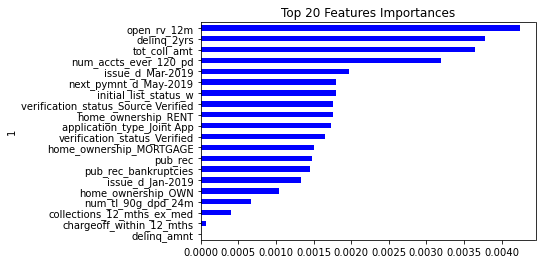

In [40]:
importance_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True))
importance_df.set_index(importance_df[1], inplace=True)
importance_df.drop(columns=1, inplace=True)
importance_df.rename(columns={0:'Feature Importances'}, inplace=True)
importance_sorted = importance_df.sort_values(by='Feature Importances').head(20)
importance_sorted.plot(kind='barh', color='blue', title='Top 20 Features Importances', legend=False)

### Easy Ensemble Classifier
https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.EasyEnsembleClassifier.html

In [42]:
# Create an instance of an Easy Ensemble Classifier:
from imblearn.ensemble import EasyEnsembleClassifier 
eec = EasyEnsembleClassifier(n_estimators=1000, random_state=1)

In [44]:
# Train the Classifier
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=1000, random_state=1)

In [46]:
# Predict
y_pred_eec = eec.predict(X_test_scaled)

In [47]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_eec)

0.9111565113151278

In [48]:
# Display the confusion matrix
cm_eec = confusion_matrix(y_test, y_pred_eec)
cm_eec_df = pd.DataFrame(
    cm_eec, index=['Actual=No: 0', 'Actual=Yes: 1'], columns=['Predicted=No: 0', 'Predicted=Yes: 1']
)
print('Confusion Matrix:')
display(cm_eec_df)

Confusion Matrix:


,Predicted=No: 0,Predicted=Yes: 1
Actual=No: 0,91,13
Actual=Yes: 1,901,16200


In [49]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.88      0.95      0.17      0.91      0.82       104
   low_risk       1.00      0.95      0.88      0.97      0.91      0.83     17101

avg / total       0.99      0.95      0.88      0.97      0.91      0.83     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    Easy Ensemble Classifier.

2. Which model had the best recall score?

    Easy Ensemble Classifier.

3. Which model had the best geometric mean score?

    Easy Ensemble Classifier.

4. What are the top three features?

    1. open_rv_12m
    2. delinq_2yrs
    3. tot_coll_amt